In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from numpy.random import seed
from nltk.tokenize.regexp import regexp_tokenize
from nltk.tokenize import RegexpTokenizer
seed(1)
from tensorflow import random
from sklearn.metrics import confusion_matrix, classification_report
random.set_seed(1)
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from keras.utils import to_categorical
from keras.optimizers import Adam

In [2]:
# Baca data
class file_input():
    dataset = pd.read_csv("Dataset urut.csv")

inputan = file_input()
inputan.dataset.head()

,Label,Tweet
0,0,"Mau gudeg mbak Bu hj. Amad Foto dari google, s..."
1,0,"Sharing pengalaman aja, kemarin jam 18.00 bata..."
2,0,Bener bener ketawa ga habis habis gue Inget aj...
3,0,H-9. Mau ke bank rame bgt ampe antrian tempat ...
4,0,Ketika aku tersenyum bukan berarti hidupku sem...


In [3]:
#Case Folding & Noise Removal
class cleaning():
    def clean_text(text):
        text = text.lower() # lower case / case folding
        text = re.sub(r"https\S+|www\S+https\S+", '',text, flags=re.MULTILINE) # hapus url
        text = re.sub(r'#[A-Za-z0-9]+','',text) # hapus hastag
        text = re.sub(r'@[A-Za-z0-9]+','',text) # hapus mention @
        text = re.sub("'", "", text) # hapus kutip
        text = re.sub('[()!?]', ' ', text) # hapus tanda baca
        text = re.sub('\[.*?\]',' ', text) # hapus kurung siku
        text = re.sub("[^a-z0-9]"," ", text) # hapus karakter
        text = re.sub(r'\d+', '', text) # hapus angka
        return text

perbaikan = cleaning()

inputan.dataset["Tweet_clean"] = [cleaning.clean_text(i) for i in inputan.dataset["Tweet"]]
inputan.dataset["Tweet_clean"]

0      mau gudeg mbak bu hj  amad foto dari google  s...
1      sharing pengalaman aja  kemarin jam   batalin ...
2      bener bener ketawa ga habis habis gue inget aj...
3      h   mau ke bank rame bgt ampe antrian tempat d...
4      ketika aku tersenyum bukan berarti hidupku sem...
                             ...                        
995    masi ga ngerti kenapa bisa takut ketinggian   ...
996      kenapa ya gua takut banget kalo mau ngomong ...
997    takut semester ini gak bakalan maksimal  belaj...
998    setiap masuk lingkungan baru  selalu serba sal...
999    ini karena deket masa pengenalan kampus kan ra...
Name: Tweet_clean, Length: 1000, dtype: object

In [4]:
#Normalisasi
class normal:
    def normalisasi(self, text):
        import re

        dict_koreksi = {}
        file = open("list_norm.txt")
        for x in file:
            f = x.split(":") #memisahkan :
            dict_koreksi.update({f[0].strip(): f[1].strip()})

        for awal, pengganti in dict_koreksi.items():
            text = re.sub(r"\b" + awal + r"\b", pengganti, text)

        return text

norm = normal()

inputan.dataset["Tweet_clean"] = inputan.dataset["Tweet_clean"].apply(norm.normalisasi)
inputan.dataset["Tweet_clean"]


0      mau gudeg mbak ibu hj  amad foto dari google  ...
1      berbagi pengalaman aja  kemarin jam   batalkan...
2      benar benar ketawa tidak habis habis aku ingat...
3      h   mau ke bank ramai banget sampai antrian te...
4      ketika aku tersenyum bukan berarti hidupku sem...
                             ...                        
995    masih tidak erti kenapa bisa takut ketinggian ...
996      kenapa ya aku takut banget kalo mau omong at...
997    takut semester ini tidak bakalan maksimal  bel...
998    setiap masuk lingkungan baru  selalu serba sal...
999    ini karena deket masa pengenalan kampus kan ra...
Name: Tweet_clean, Length: 1000, dtype: object

In [5]:
# Filtering
class filtering:
  def clean_stopword(self, text):
    # Stopword Sastrawi
    from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

    factory = StopWordRemoverFactory()
    stopword_sastrawi = factory.get_stop_words()

    text = text.split() # pisah jadi kata per kata
    text = [w for w in text if w not in stopword_sastrawi] # hapus stopwords
    text = " ".join(w for w in text) # gabung kata jadi teks

    # Stopword NLTK
    import nltk
    from nltk.corpus import stopwords

    stopword_nltk = set(stopwords.words("indonesian")) # set stopwords indonesia
    stopword_nltk = stopword_nltk

    text = text.split() # pisah jadi kata per kata
    text = [w for w in text if w not in stopword_nltk] # hapus stopwords
    text = " ".join(w for w in text) # gabung kata jadi teks
    return text

# Stopword tambahan
  def clean_stopword_tambahan(self, text):
    with open("list_stopword_tambahan.txt", "r") as f:
        stopwords_tambahan = f.read().splitlines()

    text = text.split() # pisah jadi kata per kata
    text = [w for w in text if w not in stopwords_tambahan] # hapus stopwords
    text = " ".join(w for w in text) # gabung kata jadi teks

    return text
  
bersih = filtering()

inputan.dataset["Tweet_clean"] = inputan.dataset["Tweet_clean"].apply(bersih.clean_stopword)
inputan.dataset["Tweet_clean"] = inputan.dataset["Tweet_clean"].apply(bersih.clean_stopword_tambahan)
inputan.dataset["Tweet_clean"]


0      gudeg amad foto google sengaja teman teman mem...
1      berbagi pengalaman kemarin jam batalkan tiket ...
2      ketawa habis habis lomba balap karung balap ke...
3      bank ramai banget antrian duduknya diluar toko...
4            tersenyum hidupku sempurna mensyukuri tuhan
                             ...                        
995    erti takut ketinggian doyan manjat pohon rumah...
996    takut banget omong muncul grup panik muncul gr...
997    takut semester maksimal belajar semester pulan...
998    masuk lingkungan serba salah takut teman takut...
999    deket pengenalan kampus ramai grup takut denga...
Name: Tweet_clean, Length: 1000, dtype: object

In [6]:
# Stemming
class stemming:
  def clean_stem(self, text):
    # Stemming Sastrawi
    from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

    factory = StemmerFactory()
    stemmer_sastrawi = factory.create_stemmer()

    text = stemmer_sastrawi.stem(text)

    return text

stemmer = stemming()
inputan.dataset["Tweet_clean"] = inputan.dataset["Tweet_clean"].apply(stemmer.clean_stem)
inputan.dataset["Tweet_clean"]

0      gudeg amad foto google sengaja teman teman bay...
1      bagi alam kemarin jam batal tiket stasiun lanc...
2      ketawa habis habis lomba balap karung balap ke...
3      bank ramai banget antri duduk luar toko emas l...
4                     senyum hidup sempurna syukur tuhan
                             ...                        
995    erti takut tinggi doyan manjat pohon rumah lih...
996    takut banget omong muncul grup panik muncul gr...
997    takut semester maksimal ajar semester pulang s...
998    masuk lingkung serba salah takut teman takut t...
999    deket kenal kampus ramai grup takut dengar not...
Name: Tweet_clean, Length: 1000, dtype: object

In [7]:
class tokenisasi:
    def tokenizing(self, text):
        text = nltk.word_tokenize(text)

        return text
    
token = tokenisasi()
inputan.dataset["Tweet_clean"] = inputan.dataset["Tweet_clean"].apply(token.tokenizing)
inputan.dataset["Tweet_clean"]

0      [gudeg, amad, foto, google, sengaja, teman, te...
1      [bagi, alam, kemarin, jam, batal, tiket, stasi...
2      [ketawa, habis, habis, lomba, balap, karung, b...
3      [bank, ramai, banget, antri, duduk, luar, toko...
4               [senyum, hidup, sempurna, syukur, tuhan]
                             ...                        
995    [erti, takut, tinggi, doyan, manjat, pohon, ru...
996    [takut, banget, omong, muncul, grup, panik, mu...
997    [takut, semester, maksimal, ajar, semester, pu...
998    [masuk, lingkung, serba, salah, takut, teman, ...
999    [deket, kenal, kampus, ramai, grup, takut, den...
Name: Tweet_clean, Length: 1000, dtype: object

In [8]:
# Download hasilpreprocessing 
inputan.dataset["Tweet_clean"]
pd.DataFrame(inputan.dataset).to_csv('Hasil Proses.csv', index=False, header=True)

In [9]:
# Print label
df = pd.read_csv('Data/Hasil Proses Fix.csv')
df.head()
print(df['Label'].unique())

[0 1 2 3 4]


In [10]:
# Memisahkan kolom jadi variabel terpisah
labels = df['Label']
tweets = df['Tweet_clean']

In [11]:
# Menghitung jumlah label yg muncul
teks_count = labels.value_counts()
print(labels.value_counts())

Label
0    200
1    200
2    200
3    200
4    200
Name: count, dtype: int64


In [22]:
# Pembagian data latih dan data uji
from sklearn.model_selection import train_test_split
X = tweets
y = labels
# global X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y, random_state=42)

In [23]:
# Memetakan setiap kata ke integer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [24]:
# Text to sequence
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequence = tokenizer.texts_to_sequences(X)
max_length = max([len(s) for s in sequence])

X_train = pad_sequences(sequences_train, maxlen=max_length)
X_test = pad_sequences(sequences_test, maxlen=max_length)

In [25]:
# one hot encoding
y_train = to_categorical(y_train, 5)
y_test = to_categorical(y_test, 5)

In [26]:
# Klasifikasi teks
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
vocab_size = 10000
embedding_dim = 100
num_classes = 5
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(0.5))
model.add(LSTM(embedding_dim))
model.add(Dense(units=num_classes, activation='softmax'))
optimizer = Adam(learning_rate=0.1)
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         1000000   
                                                                 
 dropout_1 (Dropout)         (None, None, 100)         0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 5)                 505       
                                                                 
Total params: 1080905 (4.12 MB)
Trainable params: 1080905 (4.12 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
batch_size=8
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
88/88 [==============================] - 8s 49ms/step - loss: 2.4563 - accuracy: 0.2586 - val_loss: 2.2354 - val_accuracy: 0.2933
Epoch 2/50
88/88 [==============================] - 4s 40ms/step - loss: 2.3237 - accuracy: 0.2957 - val_loss: 2.3945 - val_accuracy: 0.2600
Epoch 3/50
88/88 [==============================] - 4s 43ms/step - loss: 2.4234 - accuracy: 0.2800 - val_loss: 2.5782 - val_accuracy: 0.2300
Epoch 4/50
88/88 [==============================] - 4s 41ms/step - loss: 2.3904 - accuracy: 0.3171 - val_loss: 2.6569 - val_accuracy: 0.2533
Epoch 5/50
88/88 [==============================] - 4s 42ms/step - loss: 2.5726 - accuracy: 0.2829 - val_loss: 2.4604 - val_accuracy: 0.3200
Epoch 6/50
88/88 [==============================] - 4s 45ms/step - loss: 2.3962 - accuracy: 0.3071 - val_loss: 2.2630 - val_accuracy: 0.2867
Epoch 7/50
88/88 [==============================] - 4s 41ms/step - loss: 2.5036 - accuracy: 0.2757 - val_loss: 2.5564 - val_accuracy: 0.2667
Epoch 8/50
88

In [28]:
accuracy = model.evaluate(X_test, y_test, verbose=2, batch_size=batch_size)
y_pred = model.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

38/38 - 0s - loss: 2.6290 - accuracy: 0.3033 - 213ms/epoch - 6ms/step
10/10 [==============================] - 1s 11ms/step


In [434]:
model.save('TestModelFix.h5')

C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


C:\Users\USER\AppData\Local\Temp\ipykernel_7216\4187475362.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, history.history['loss'], 'b', label='training loss', color='red')


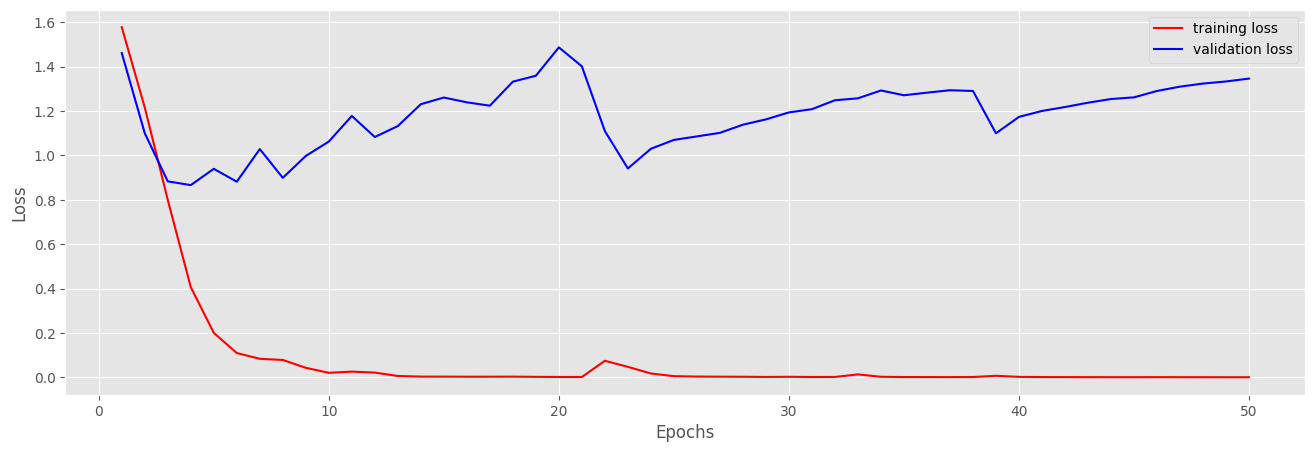

In [19]:
# kofigurasi percobaan model kurva loss
plt.figure(figsize=(16,5))
epochs = range(1, len(history.history['accuracy'])+1)
plt.plot(epochs, history.history['loss'], 'b', label='training loss', color='red')
plt.plot(epochs, history.history['val_loss'], 'b', label='validation loss')
plt.legend()
plt.xlabel('Epochs')  # Menambahkan keterangan sumbu x
plt.ylabel('Loss')  # Menambahkan keterangan sumbu y
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_7216\1084645551.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, history.history['accuracy'], 'b', label='training accuracy', color='red')


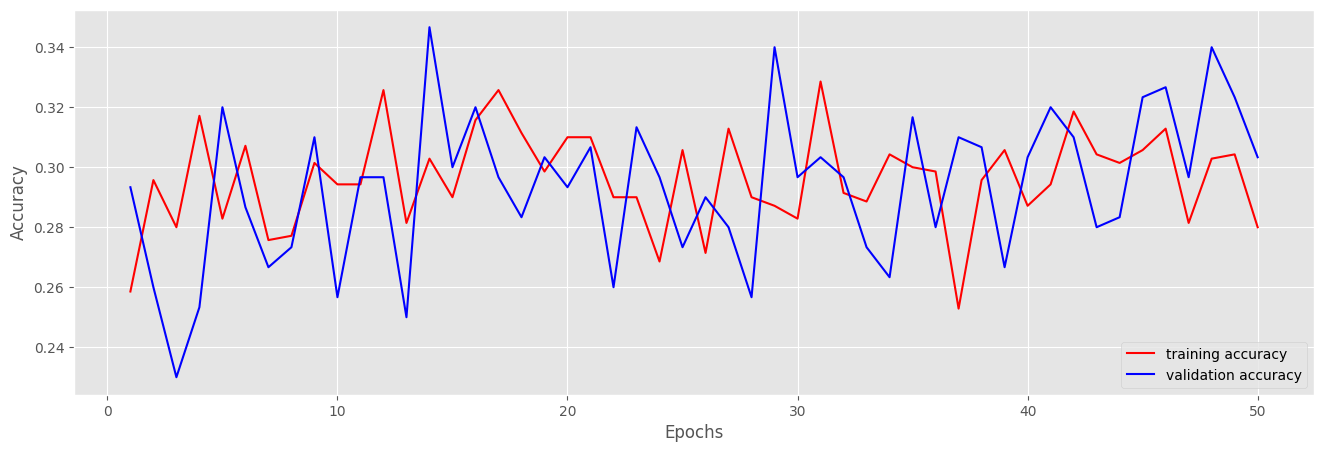

In [29]:
# kofigurasi percobaan model kurva accuracy
plt.figure(figsize=(16,5))
epochs = range(1, len(history.history['accuracy'])+1)
plt.plot(epochs, history.history['accuracy'], 'b', label='training accuracy', color='red')
plt.plot(epochs, history.history['val_accuracy'], 'b', label='validation accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epochs')  # Menambahkan keterangan sumbu x
plt.ylabel('Accuracy')  # Menambahkan keterangan sumbu y
plt.show()

In [436]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test,y_pred)
print(cm)

[[42  4  7  6  1]
 [ 2 42  5  5  6]
 [ 9  3 39  1  8]
 [ 3  0  2 55  0]
 [ 3  5  2  0 50]]


In [437]:
print(classification_report(y_test, y_pred, target_names=['Happy', 'Sadness', 'Anger', 'Love', 'Fear']))

              precision    recall  f1-score   support

       Happy       0.71      0.70      0.71        60
     Sadness       0.78      0.70      0.74        60
       Anger       0.71      0.65      0.68        60
        Love       0.82      0.92      0.87        60
        Fear       0.77      0.83      0.80        60

    accuracy                           0.76       300
   macro avg       0.76      0.76      0.76       300
weighted avg       0.76      0.76      0.76       300

